In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use('seaborn-whitegrid')

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class MultiRBFnn(nn.Module):
    def __init__(self, in_feature, add_rbf_num, device):
        super(MultiRBFnn, self).__init__()

        self.add_rbf_num = add_rbf_num  # additional RBFs number
        self.in_feature = in_feature    # count features
        self.device = device
        self.centers_list = []
        self.sigmas_list = []
        self.weights_list = []

        self.change_th = 3

    def first_rbf_parameter(self, input_data, target): # done

        # input_data shape : (data_num)
        # target data shape : (in_feature, data_num)
        
        # first layer centers, weights, sigmas
        # centers, sigmas : (add_rbf_num, 1)
        # weights : (in_feature, add_rbf_num)

        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()

        find_sigma = target.clone().detach()
        find_weight = target.clone().detach()
        center_index_list = []

        # first MultiRBFs initial centers and weights parameters
        for i in range(self.add_rbf_num):
            index_ = torch.argmax(torch.sum(torch.abs(fine_index_target), dim = 0)).cpu().detach().tolist()
            fine_index_target[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device= self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)

        # first MultiRBFs initial sigmas parameters                
        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        dft =  torch.abs(dft / torch.max(dft)) **-1
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,k]).reshape(1))

        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num, 1)

        # print(initcenter, initweight, initsigma)
        return initcenter, initweight, initsigma
    
    def add_rbf_parameter(self, input_data, error):
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = error.clone().detach()
        
        center_index_list = []

        for i in range(self.add_rbf_num * (self.change_time + 1)):
            index_ = torch.argmax(torch.sum(torch.abs(find_index_error), dim = 0)).cpu().detach().tolist()

            find_index_error[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[::,-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)


        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        
        dft = (torch.abs(dft / torch.max(dft))**-1)
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,k]).reshape(1))
        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        #print(initcenter, initweight, initsigma)
        return initcenter, initweight, initsigma
    
    
    def rbf_gaussian(self, input_data):
        out = torch.exp(-1 *(torch.pow((input_data - self.centers), 2)) / (torch.pow(self.sigma, 2)))

        return out

    def forward(self, input_data):
        R = self.rbf_gaussian(input_data)
        pred = torch.mm(self.weights, R)

        return R, pred

    def rbf_gaussian_derivative_centers(self, input_data): # done
        output = (2 * (input_data - self.centers) / (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)

    def rbf_gaussian_derivative_sigma(self, input_data): # done
        output = (2 * torch.pow((input_data - self.centers), 2) / (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)
    
    # FUNCTION GRADIENT
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data-centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.mm(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data, target):
        space = (input_data,)
        f_grad = torch.gradient(target[0], spacing = space, edge_order  = 1)
        return f_grad[0]
    
    def target_grad(self, input_data, centers, sigmas, weights, f_grad):
        true_grad = f_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
        
        return true_grad
    
    def rbf_gaussian_derivative_centers(self, input_data):
        output = (2 * (input_data - self.centers) / \
                  (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gaussian_derivative_sigma(self, input_data):
        output = (2 * torch.pow((input_data - self.centers), 2) / \
                (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)

    def L2_F(self, input_data):
        return -2 * (input_data - self.centers) / torch.pow(self.sigma, 2)
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.centers) / torch.pow(self.sigma,2)) * radial_output


    # Backpropagation and train

    def BP(self, input_data, target, R, pred, target_grad, pred_grad):
        L2_1_error = -2 * (target - pred)

        L2_2_error = -2 * (target_grad - pred_grad)


        # sigma update
        deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaSigma1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaSigma2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaSigma =  torch.mean(torch.sum(deltaSigma1, dim=2), dim = 0) + torch.mean(torch.sum(deltaSigma2, dim=2), dim = 0)

        # center update
        deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaCenter1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaCenter2 = self.rbf_gaussian_derivative_centers(input_data) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaCenter2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)
        deltaCenter =  torch.mean(torch.sum(deltaCenter1, dim=2), dim = 0) + torch.mean(torch.sum(deltaCenter2, dim=2), dim = 0)

        
        # weight update
        delta_weight1 = torch.sum((R * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))), dim=2)
        delta_weight2 = torch.sum(self.L2_2_derivateive_weight(input_, R) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0)), dim = 2)
        delta_weight = delta_weight1 + delta_weight2
        
        # BP update
        self.weights -= self.lr * delta_weight
        #self.centers -= self.lr * torch.sum(deltaCenter1, dim=1).reshape(self.add_rbf_num, 1)
        #self.sigma -= self.lr * torch.sum(deltaSigma1, dim=1).reshape(self.add_rbf_num, 1)
        self.centers -= self.lr * deltaCenter.reshape(self.add_rbf_num, 1)
        self.sigma -= self.lr * deltaSigma.reshape(self.add_rbf_num, 1)

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1
    
    def plot_train(self, input_data, best_pred): #done
        if self.in_feature != 1:
            fig, ax = plt.subplots(1, self.in_feature, figsize = (30, 5))
            for i in range(self.in_feature):
                ax[i].plot(input_data.cpu().detach().numpy(), self.target[i].cpu().detach().numpy())
                ax[i].plot(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
            plt.show()
        
        else:
            plt.plot(input_data.cpu().detach().numpy(), self.target[0].cpu().detach().numpy())
            plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
            plt.show()

    def best_forward(self, input_data, best_center, best_sigma, best_weight): # ?
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                        (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight, rbf_output)

        return pred
    
    def Loss(self, pred, target, pred_grad, true_grad):
        # value L2 loss  

        return torch.mean(torch.pow(target - pred,2) + torch.pow(true_grad - pred_grad, 2)) 
    
    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_centers), 2) / \
                                     (torch.pow(self.done_sigma, 2))))
        pred = torch.mm(self.done_weights, rbf_output)

        return rbf_output, pred
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th):
        self.lr = lr
        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.lr_change_th = lr_change_th
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.round_number = 5
        self.change_time = 0
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_num

        loss = 100000
        
        while self.loss_th < loss:

            print("{}th additional rbflayer".format(self.number))
            # first rbflayer
            if self.number == 0:
                self.centers, self.weights, self.sigma = self.first_rbf_parameter(input_data, self.target)
                first_grad = self.first_grad(input_data, target)
                for epoch in range(epochs):
                    # print("epoch : {}".format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)

                    self.BP(input_data, self.target, R, pred, first_grad, rbf_grad)
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    epoch_loss = self.Loss(pred, self.target, rbf_grad, first_grad)

                    if epoch == 0:
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch, epoch_loss))
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                    
                    else:
                        if self.best_loss > epoch_loss:
                            self.best_loss = epoch_loss.clone().detach()
                            self.best_center = self.centers.clone().detach()
                            self.best_sigma = self.sigma.clone().detach()
                            self.best_weight = self.weights.clone().detach()

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))

            else:
                self.change_init(na)
                if self.change_time > break_time:
                    break
                
                
                self.centers, self.weights, self.sigma = self.add_rbf_parameter(input_data, self.target)

                for epoch in range(epochs):
                    # print('epoch : {}'.format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    if epoch == 0:
                        
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch,
                                                                                        self.Loss(pred, self.target, rbf_grad, target_grad)))
                        self.best_loss = self.Loss(pred, self.target, rbf_grad, target_grad).clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()

                    self.BP(input_data, self.target, R, pred, target_grad, rbf_grad)
                    # R, pred = self.forward(input_data)
                    # rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    epoch_loss = self.Loss(pred, self.target, rbf_grad, target_grad)

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))
                    
                    if self.best_loss > epoch_loss:
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                
            best_pred = self.best_forward(input_data, self.best_center, self.best_sigma, self.best_weight)
            best_grad = self.rbf_gradient(input_data, self.best_center, self.best_sigma, self.best_weight)
            if self.number ==0:
                train_loss = self.Loss(best_pred, self.target, best_grad, first_grad)
            else:
                train_loss = self.Loss(best_pred, self.target, best_grad, target_grad)

            print("{}th additional RBFlayer best loss : {}".format(self.number, train_loss))

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.03
                print("change lr ", self.lr)
                print('----------------------------------------------')
                
            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')
                
            self.train_loss_list.append(train_loss)

            # additional rbf plot print
            self.plot_train(input_data, best_pred)

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.centers_list.append(self.best_center)
                self.sigmas_list.append(self.best_sigma)
                self.weights_list.append(self.best_weight)

                self.done_centers = torch.cat(self.centers_list, dim  =0)
                self.done_sigma = torch.cat(self.sigmas_list, dim = 0)
                self.done_weights = torch.cat(self.weights_list, dim = 1)
                target_grad = self.target_grad(input_data, self.done_centers, self.done_sigma, self.done_weights, first_grad)

            else:
                na = 0
    

In [4]:
from scipy.integrate import odeint

def lorenz(x, t, F):
    '''Partial derivatives for Lorenz-96 ODE.'''
    p = len(x)
    dxdt = np.zeros(p)
    for i in range(p):
        dxdt[i] = (x[(i+1) % p] - x[(i-2) % p]) * x[(i-1) % p] - x[i] + F

    return dxdt

def simulate_lorenz_96(p, T, F=10.0, delta_t=0.1, sd=0.1, burn_in=1000,
                       seed=0):
    if seed is not None:
        np.random.seed(seed)

    # Use scipy to solve ODE.
    x0 = np.random.normal(scale=0.01, size=p)
    t = np.linspace(0, (T + burn_in) * delta_t, T + burn_in)
    X = odeint(lorenz, x0, t, args=(F,))
    X += np.random.normal(scale=sd, size=(T + burn_in, p))

    # Set up Granger causality ground truth.
    GC = np.zeros((p, p), dtype=int)
    for i in range(p):
        GC[i, i] = 1
        GC[i, (i + 1) % p] = 1
        GC[i, (i - 1) % p] = 1
        GC[i, (i - 2) % p] = 1

    return X[burn_in:], GC

In [5]:
X_np, GC = simulate_lorenz_96(p=10, F=10, T=1000)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float64, device=device)
X = X.reshape(10,1000)
input_ = torch.arange(0,1000, 1, device = device, dtype = float)

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 63.504295833395766
0th additional RBFlayer 999th epoch MSE Loss: 32.026898088617756
0th additional RBFlayer 1999th epoch MSE Loss: 31.567582236151456
0th additional RBFlayer 2999th epoch MSE Loss: 31.22807204562428
0th additional RBFlayer best loss : 31.222978331109452


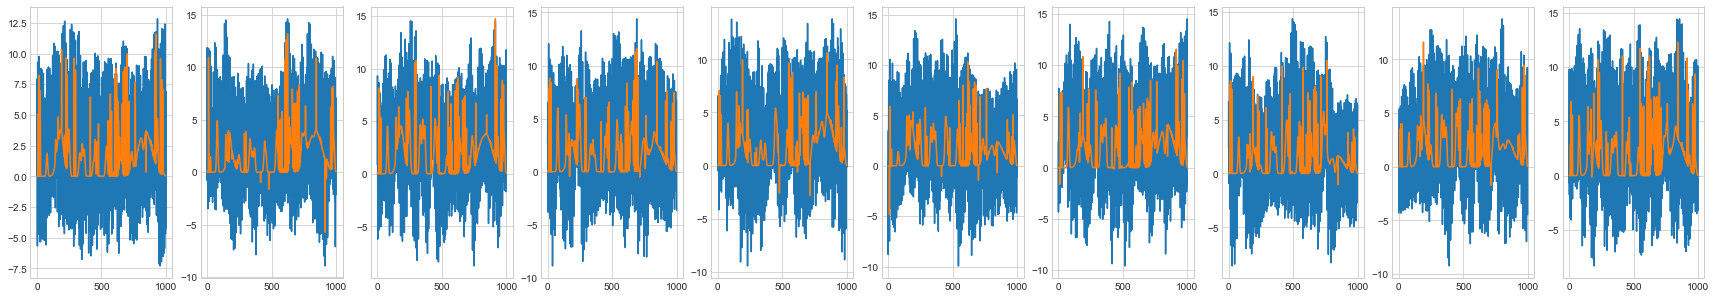

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 39.42851456495952
1th additional RBFlayer 999th epoch MSE Loss: 28.324509175225465
1th additional RBFlayer 1999th epoch MSE Loss: 28.080615532870745
1th additional RBFlayer 2999th epoch MSE Loss: 27.952541128516692
1th additional RBFlayer best loss : 27.952541128516692


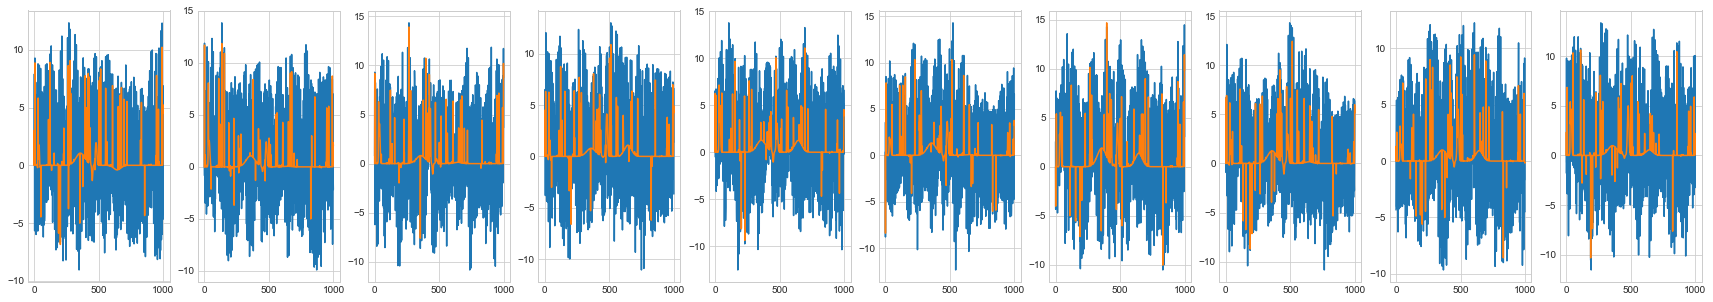

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 36.49358955578136
2th additional RBFlayer 999th epoch MSE Loss: 26.695640147898622
2th additional RBFlayer 1999th epoch MSE Loss: 26.422888837037185
2th additional RBFlayer 2999th epoch MSE Loss: 26.368549252242538
2th additional RBFlayer best loss : 26.36375260390012


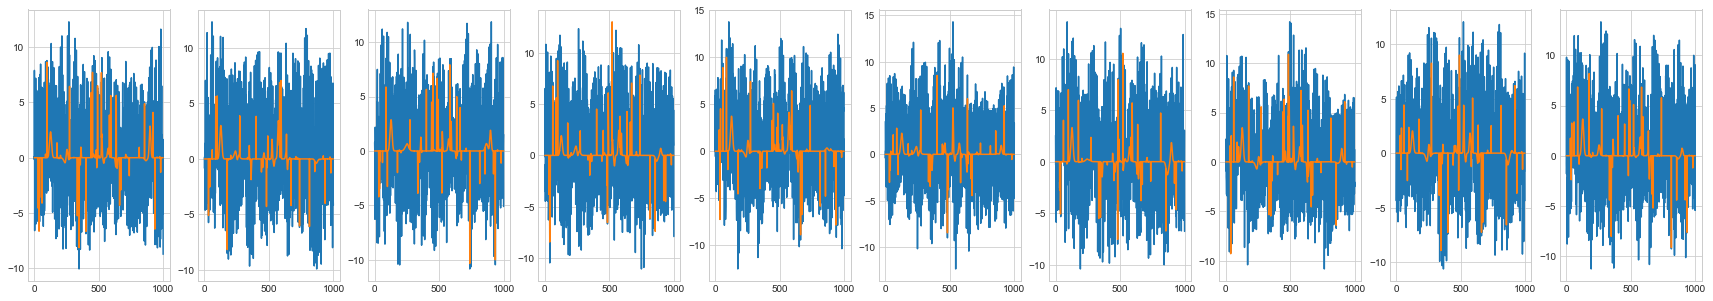

3th additional rbflayer
3th additional RBFlayer 0th epoch loss: 32.20122212606215
3th additional RBFlayer 999th epoch MSE Loss: 25.470039968553575
3th additional RBFlayer 1999th epoch MSE Loss: 25.37296356944747
3th additional RBFlayer 2999th epoch MSE Loss: 25.31847830859092
3th additional RBFlayer best loss : 25.317365231863015


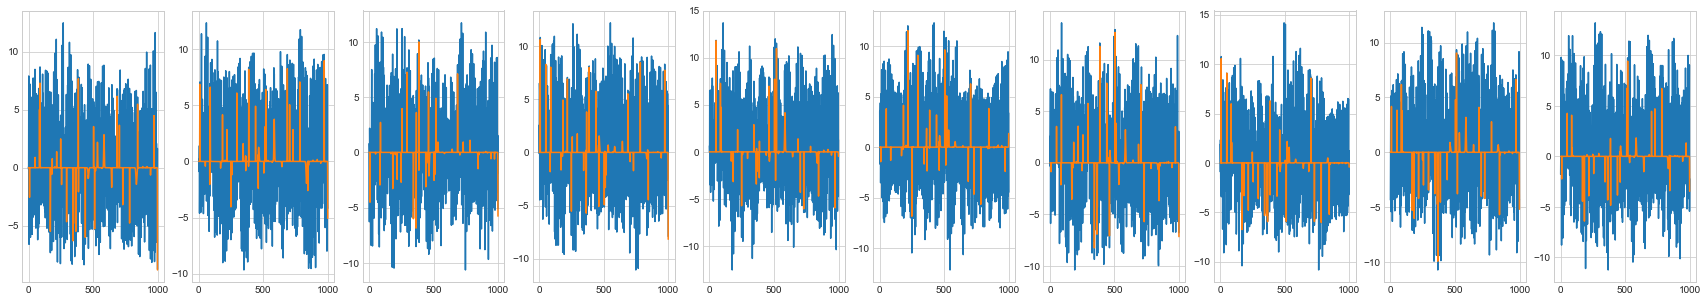

4th additional rbflayer
4th additional RBFlayer 0th epoch loss: 37.418559175723374
4th additional RBFlayer 999th epoch MSE Loss: 24.749164875871028
4th additional RBFlayer 1999th epoch MSE Loss: 24.63782541260641
4th additional RBFlayer 2999th epoch MSE Loss: 24.600038357514908
4th additional RBFlayer best loss : 24.60001159146417


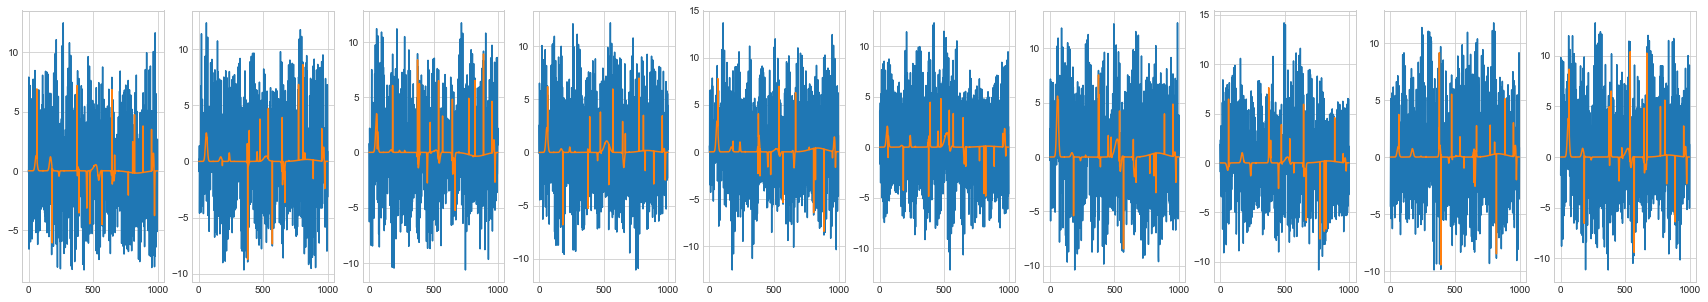

5th additional rbflayer
5th additional RBFlayer 0th epoch loss: 31.62697039206077
5th additional RBFlayer 999th epoch MSE Loss: 23.978983190267353
5th additional RBFlayer 1999th epoch MSE Loss: 23.880996104104394
5th additional RBFlayer 2999th epoch MSE Loss: 23.850284737946733
5th additional RBFlayer best loss : 23.850307601015142


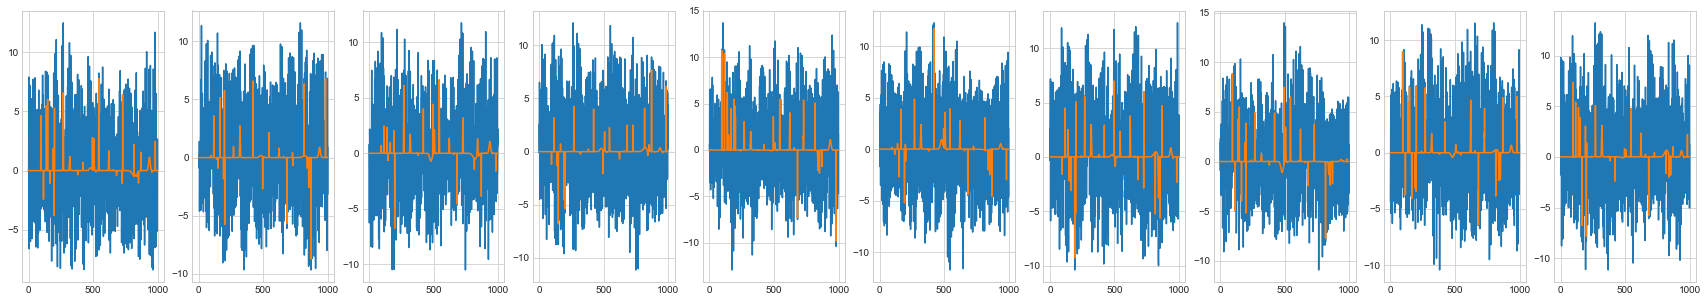

6th additional rbflayer
6th additional RBFlayer 0th epoch loss: 33.11791871165075
6th additional RBFlayer 999th epoch MSE Loss: 23.097592300149962
6th additional RBFlayer 1999th epoch MSE Loss: 23.07141303123133
6th additional RBFlayer 2999th epoch MSE Loss: 23.013813475580328
6th additional RBFlayer best loss : 23.013813475580328


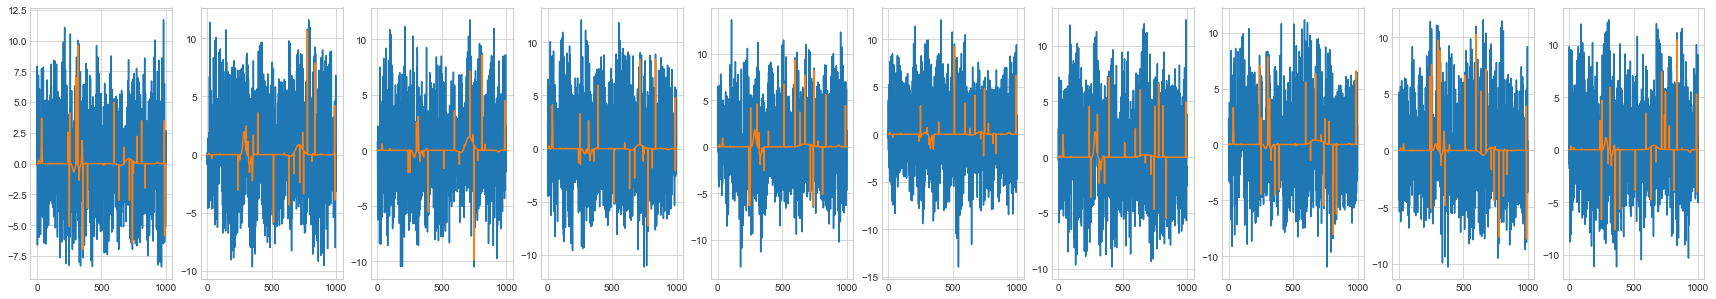

7th additional rbflayer
7th additional RBFlayer 0th epoch loss: 31.52078582739439
7th additional RBFlayer 999th epoch MSE Loss: 22.665586180377492
7th additional RBFlayer 1999th epoch MSE Loss: 22.603756518613345
7th additional RBFlayer 2999th epoch MSE Loss: 22.585721084376942
7th additional RBFlayer best loss : 22.58569005865639


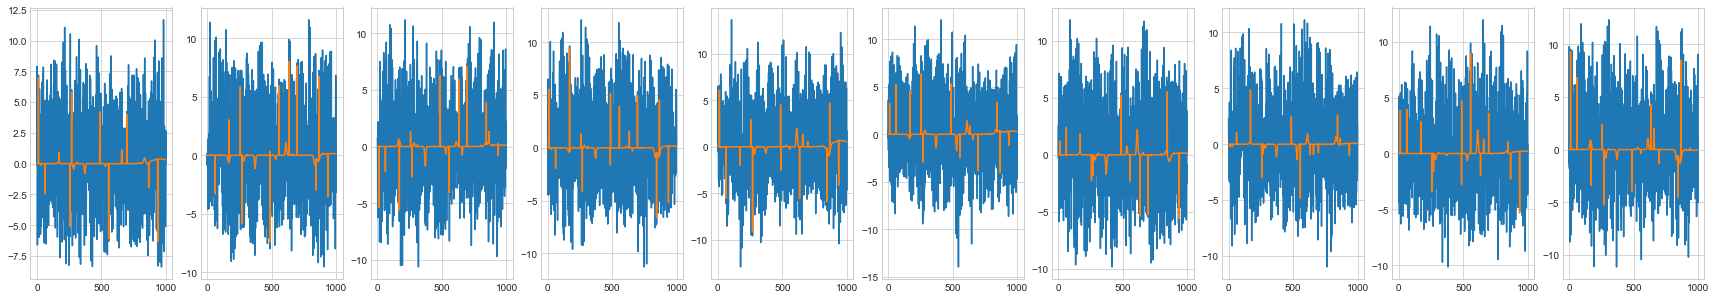

8th additional rbflayer
8th additional RBFlayer 0th epoch loss: 31.887143098461635
8th additional RBFlayer 999th epoch MSE Loss: 22.218736690622443
8th additional RBFlayer 1999th epoch MSE Loss: 22.200362346308967
8th additional RBFlayer 2999th epoch MSE Loss: 22.173521628553125
8th additional RBFlayer best loss : 22.173510592650622


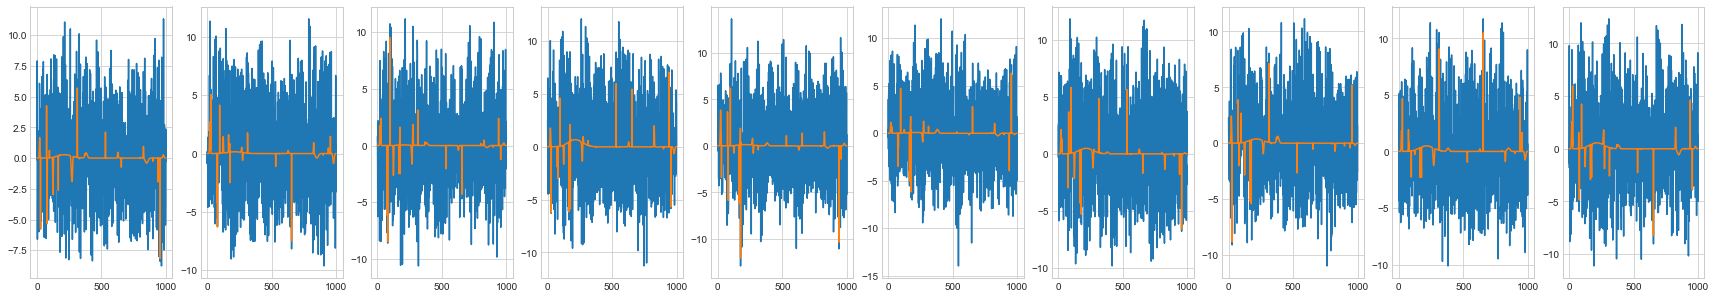

9th additional rbflayer
9th additional RBFlayer 0th epoch loss: 29.0366363758376
9th additional RBFlayer 999th epoch MSE Loss: 21.894164797112673
9th additional RBFlayer 1999th epoch MSE Loss: 21.846282775350083
9th additional RBFlayer 2999th epoch MSE Loss: 21.823867084527492
9th additional RBFlayer best loss : 21.823848377863968


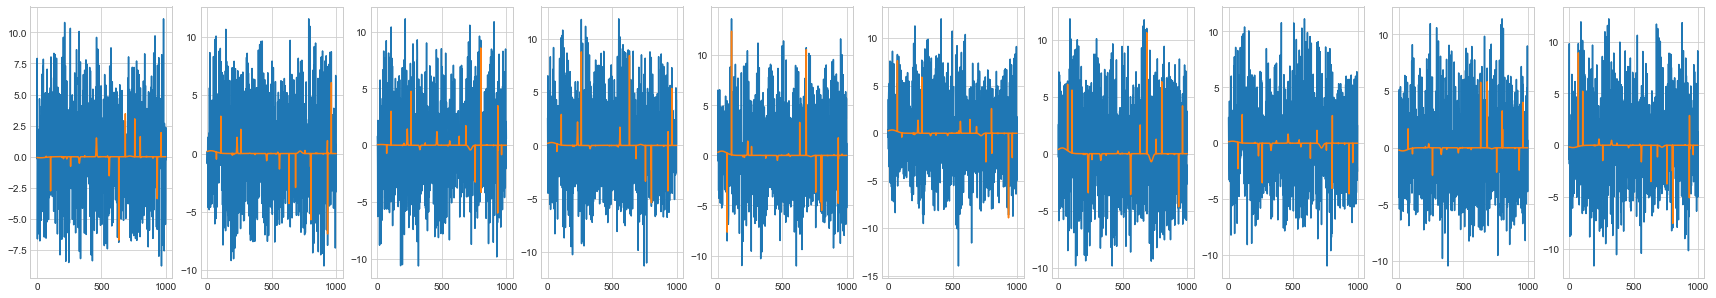

10th additional rbflayer
10th additional RBFlayer 0th epoch loss: 27.118412483443905
10th additional RBFlayer 999th epoch MSE Loss: 21.495391547034803
10th additional RBFlayer 1999th epoch MSE Loss: 21.474322664907543
10th additional RBFlayer 2999th epoch MSE Loss: 21.474313487823856
10th additional RBFlayer best loss : 21.449890633333865


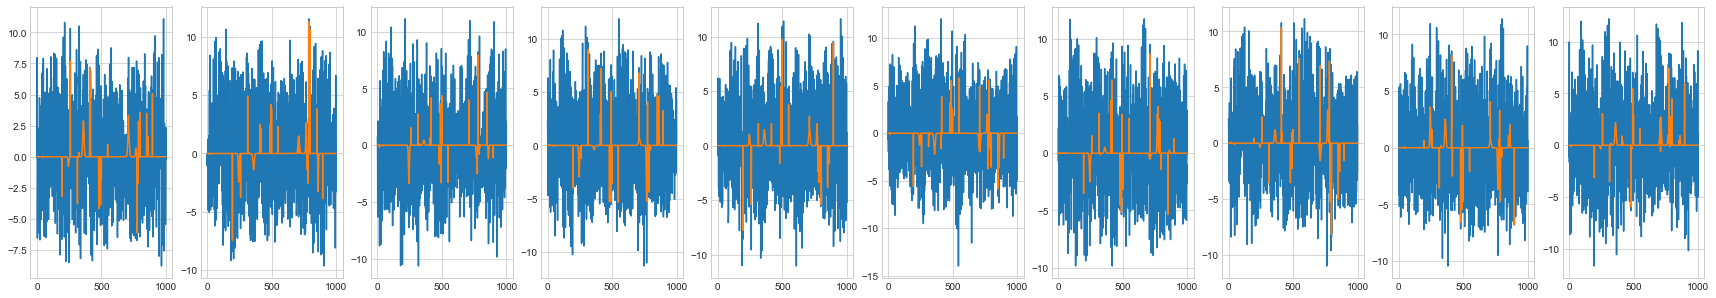

11th additional rbflayer
11th additional RBFlayer 0th epoch loss: 34.47033624740263
11th additional RBFlayer 999th epoch MSE Loss: 21.049943385749213
11th additional RBFlayer 1999th epoch MSE Loss: 20.921906570572133
11th additional RBFlayer 2999th epoch MSE Loss: 20.920397205047614
11th additional RBFlayer best loss : 20.919695392587666


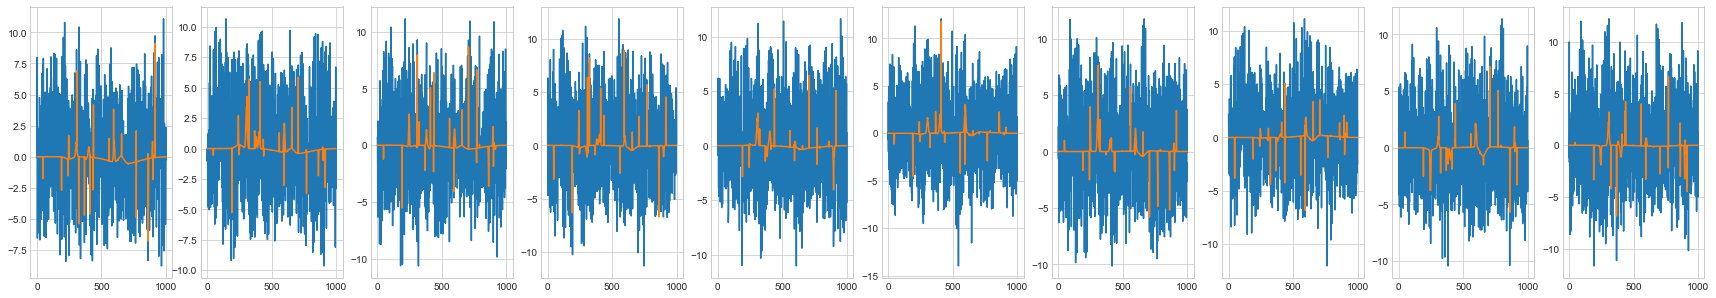

12th additional rbflayer
12th additional RBFlayer 0th epoch loss: 26.589508166013623
12th additional RBFlayer 999th epoch MSE Loss: 20.545492378947177
12th additional RBFlayer 1999th epoch MSE Loss: 20.504750933985264
12th additional RBFlayer 2999th epoch MSE Loss: 20.47123123166924
12th additional RBFlayer best loss : 20.47119573588561


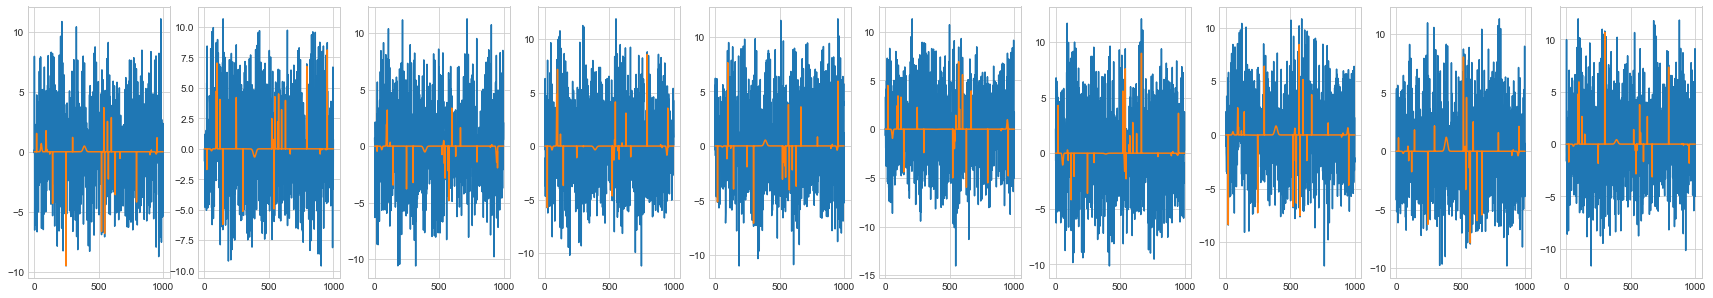

13th additional rbflayer
13th additional RBFlayer 0th epoch loss: 26.482455663552916
13th additional RBFlayer 999th epoch MSE Loss: 20.157366474887034
13th additional RBFlayer 1999th epoch MSE Loss: 20.081392797154752
13th additional RBFlayer 2999th epoch MSE Loss: 20.057578365132127
13th additional RBFlayer best loss : 20.057772627387237


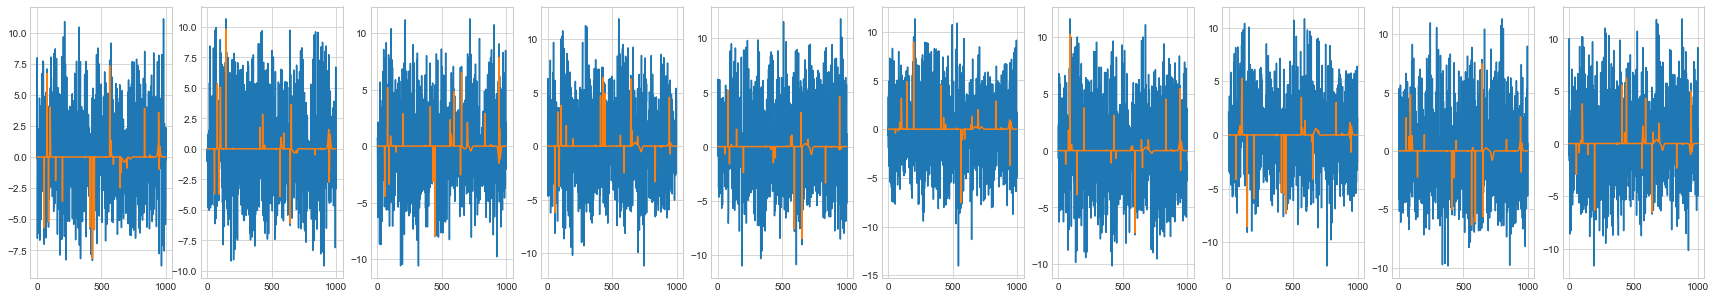

14th additional rbflayer
14th additional RBFlayer 0th epoch loss: 24.775385066788402
14th additional RBFlayer 999th epoch MSE Loss: 19.71127693643169
14th additional RBFlayer 1999th epoch MSE Loss: 19.686057233398646
14th additional RBFlayer 2999th epoch MSE Loss: 19.652296292197246
14th additional RBFlayer best loss : 19.652296292197246
change lr  0.001
----------------------------------------------


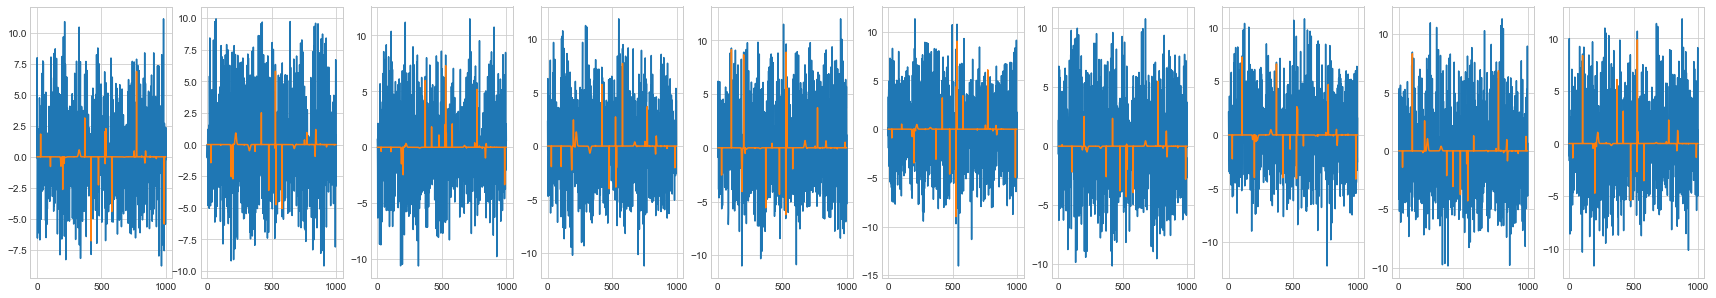

15th additional rbflayer
15th additional RBFlayer 0th epoch loss: 29.017764933379578
15th additional RBFlayer 999th epoch MSE Loss: 19.300536966415663
15th additional RBFlayer 1999th epoch MSE Loss: 19.27489501346201
15th additional RBFlayer 2999th epoch MSE Loss: 19.32804281246925
15th additional RBFlayer best loss : 19.271412357243083


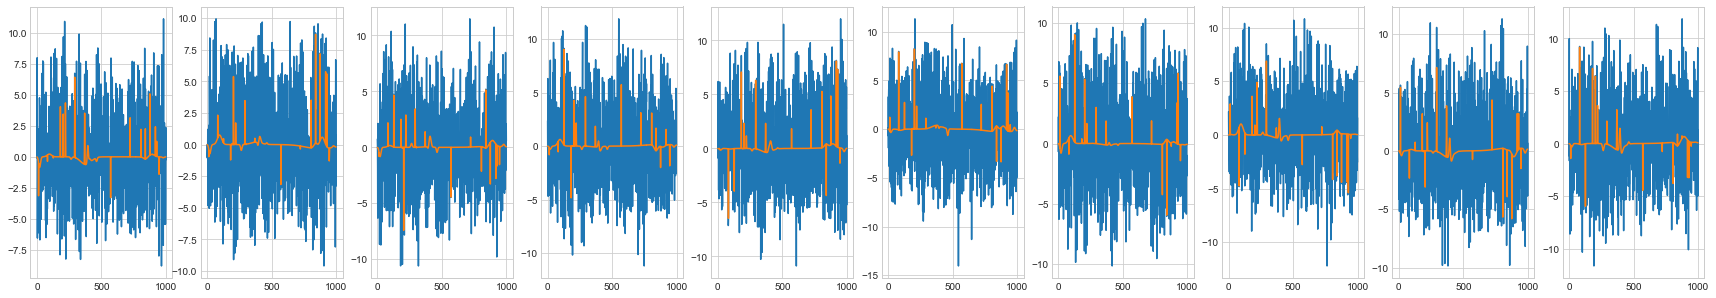

16th additional rbflayer
16th additional RBFlayer 0th epoch loss: 26.204289612863505
16th additional RBFlayer 999th epoch MSE Loss: 18.862140921912445
16th additional RBFlayer 1999th epoch MSE Loss: 18.837893593290477
16th additional RBFlayer 2999th epoch MSE Loss: 18.85207145801349
16th additional RBFlayer best loss : 18.83530316406848


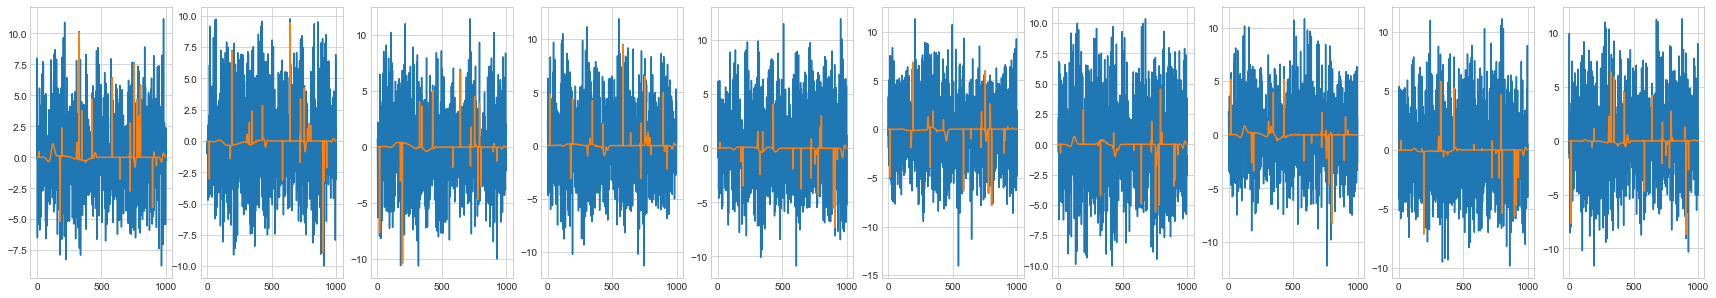

17th additional rbflayer
17th additional RBFlayer 0th epoch loss: 30.545034608495154
17th additional RBFlayer 999th epoch MSE Loss: 18.44792712166836
17th additional RBFlayer 1999th epoch MSE Loss: 18.46411385337836
17th additional RBFlayer 2999th epoch MSE Loss: 18.491969221840627
17th additional RBFlayer best loss : 18.44464941949298


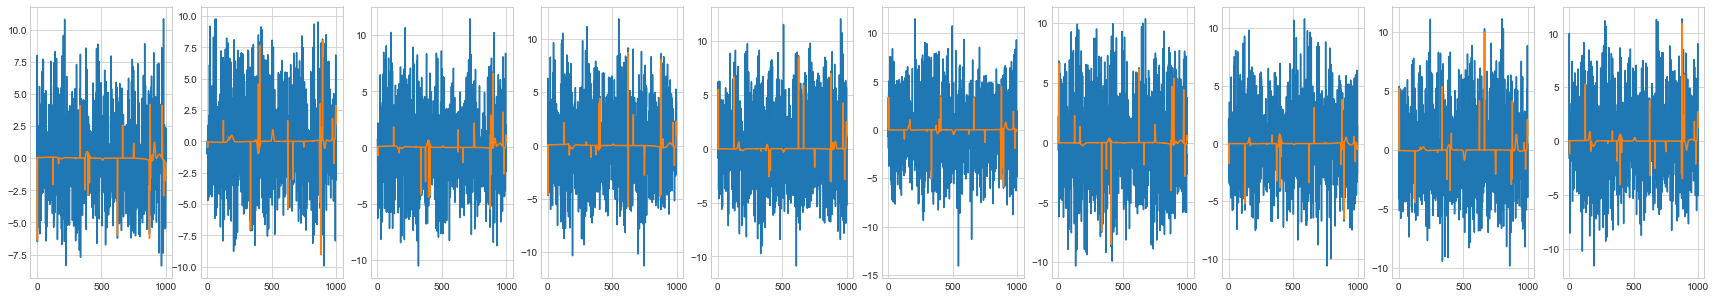

18th additional rbflayer
18th additional RBFlayer 0th epoch loss: 23.92887133750681
18th additional RBFlayer 999th epoch MSE Loss: 18.103782599776405
18th additional RBFlayer 1999th epoch MSE Loss: 18.090183983258495
18th additional RBFlayer 2999th epoch MSE Loss: 18.05854534313912
18th additional RBFlayer best loss : 18.05596710298959


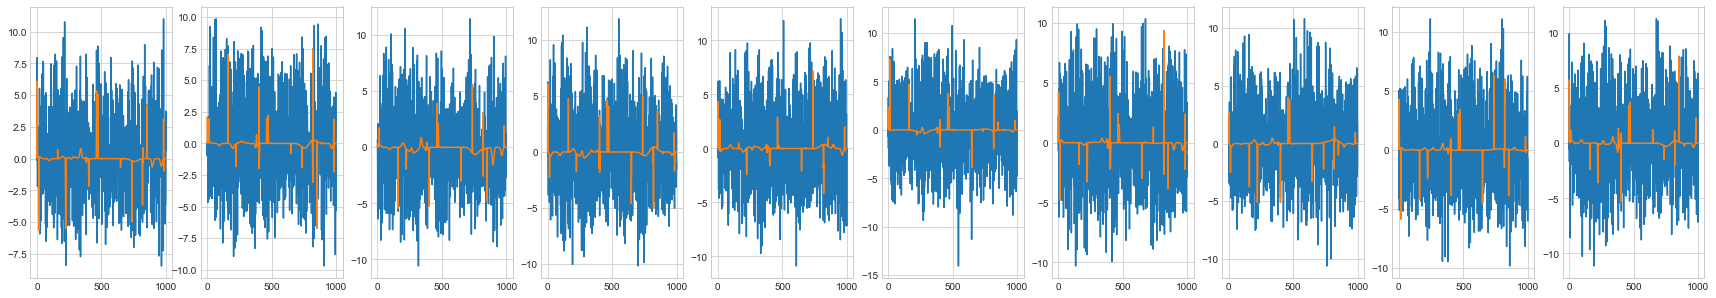

19th additional rbflayer
19th additional RBFlayer 0th epoch loss: 23.34324684429241
19th additional RBFlayer 999th epoch MSE Loss: 17.509294067124447
19th additional RBFlayer 1999th epoch MSE Loss: 17.484057337933397
19th additional RBFlayer 2999th epoch MSE Loss: 17.495935106435745
19th additional RBFlayer best loss : 17.46931074029698


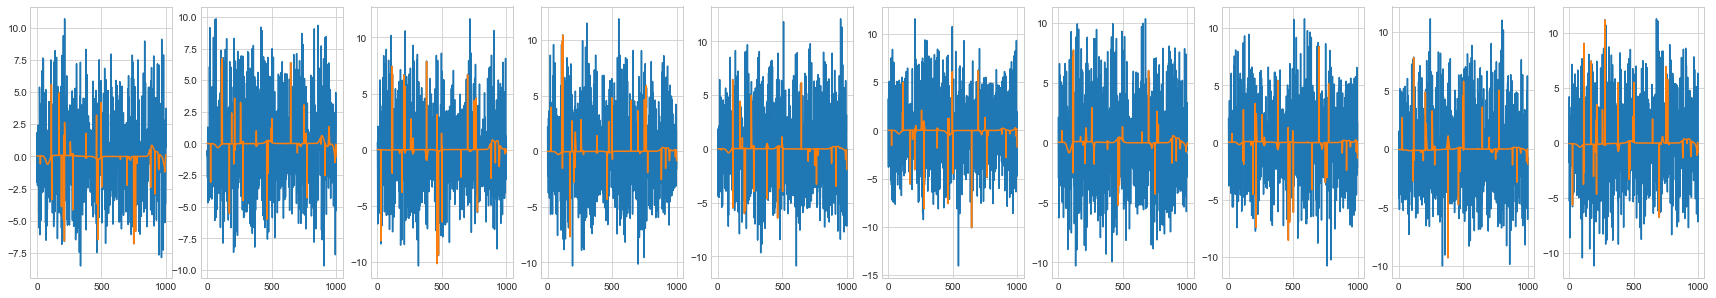

20th additional rbflayer
20th additional RBFlayer 0th epoch loss: 23.79021308027977
20th additional RBFlayer 999th epoch MSE Loss: 17.086343526368704
20th additional RBFlayer 1999th epoch MSE Loss: 17.084070310382998
20th additional RBFlayer 2999th epoch MSE Loss: 17.078131917473442
20th additional RBFlayer best loss : 17.056927760456595


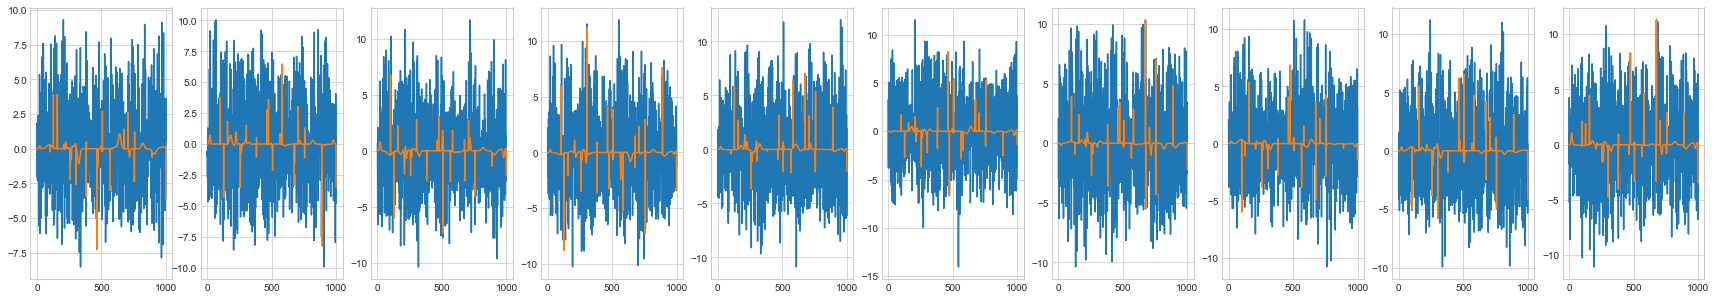

21th additional rbflayer
21th additional RBFlayer 0th epoch loss: 23.578962554269584
21th additional RBFlayer 999th epoch MSE Loss: 16.62446224823145
21th additional RBFlayer 1999th epoch MSE Loss: 16.637665309294928
21th additional RBFlayer 2999th epoch MSE Loss: 16.676393382964097
21th additional RBFlayer best loss : 16.585840829120997


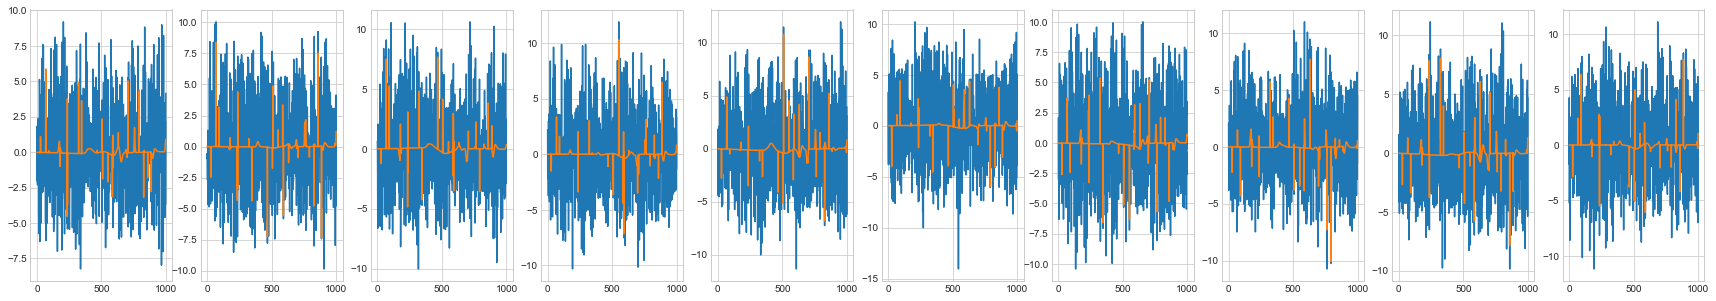

22th additional rbflayer
22th additional RBFlayer 0th epoch loss: 24.0590207775347
22th additional RBFlayer 999th epoch MSE Loss: 16.134067613904342
22th additional RBFlayer 1999th epoch MSE Loss: 16.16353258080665
22th additional RBFlayer 2999th epoch MSE Loss: 16.187999697594584
22th additional RBFlayer best loss : 16.109751197828576


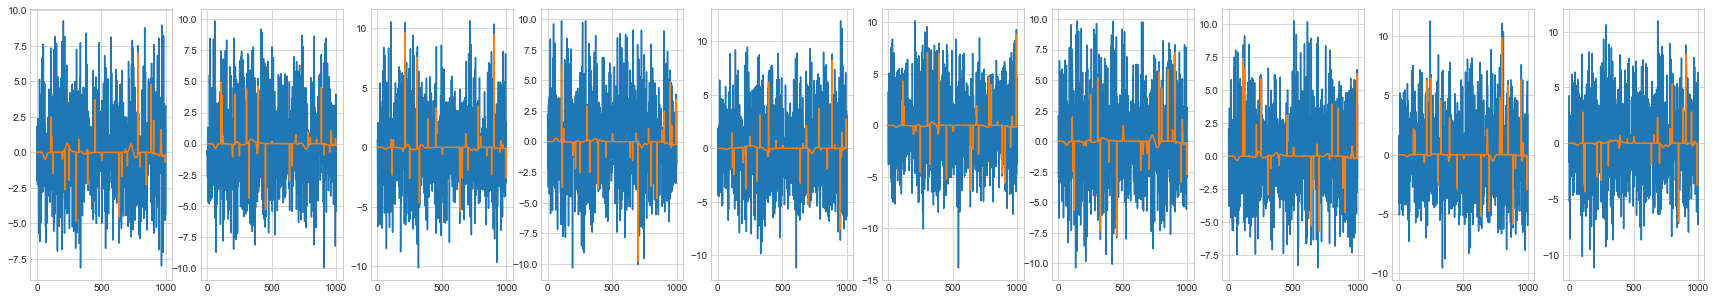

23th additional rbflayer
23th additional RBFlayer 0th epoch loss: 20.352225721288644
23th additional RBFlayer 999th epoch MSE Loss: 15.640882322188368
23th additional RBFlayer 1999th epoch MSE Loss: 15.55880163491777
23th additional RBFlayer 2999th epoch MSE Loss: 15.561970875316884
23th additional RBFlayer best loss : 15.550482916830084


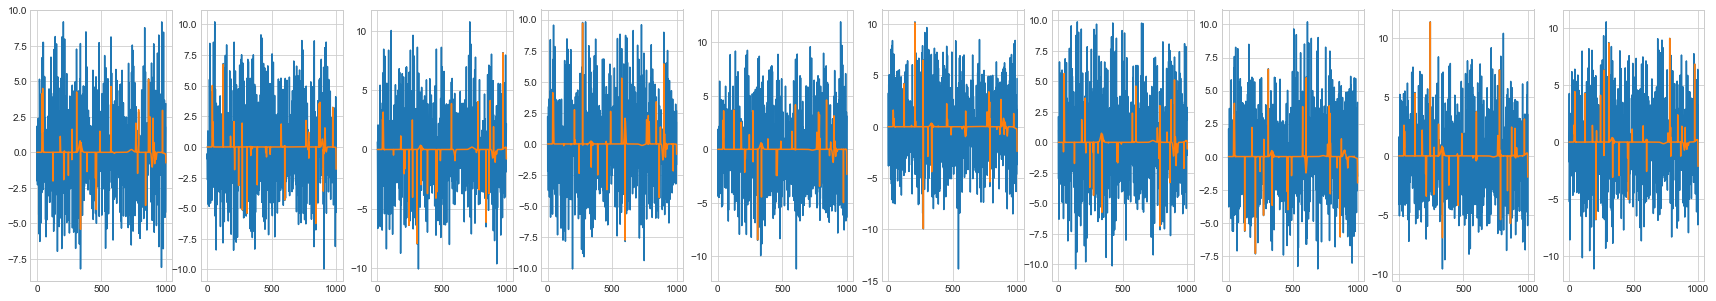

24th additional rbflayer
24th additional RBFlayer 0th epoch loss: 19.65371079414417
24th additional RBFlayer 999th epoch MSE Loss: 15.176786312334066
24th additional RBFlayer 1999th epoch MSE Loss: 15.162901667320735
24th additional RBFlayer 2999th epoch MSE Loss: 15.138080782097578
24th additional RBFlayer best loss : 15.137202609668208


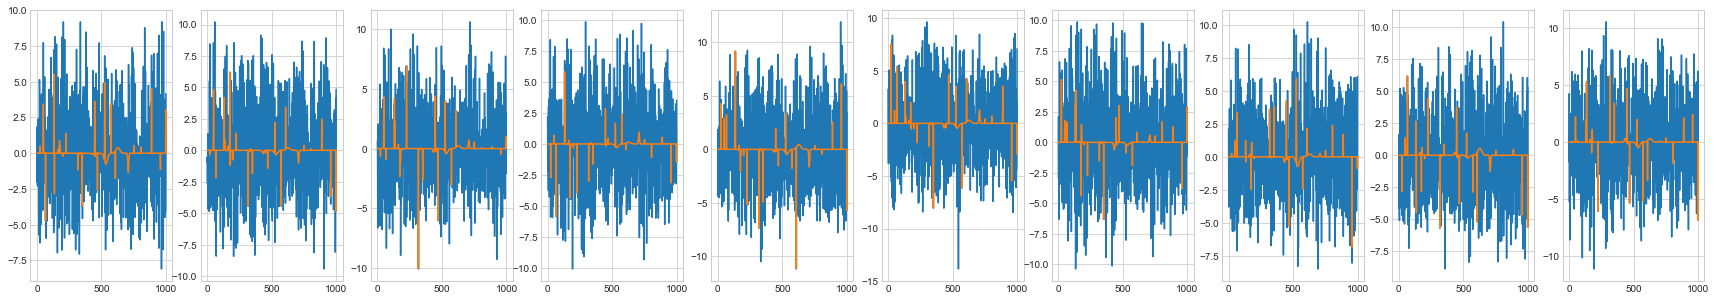

25th additional rbflayer
25th additional RBFlayer 0th epoch loss: 20.902297122970644
25th additional RBFlayer 999th epoch MSE Loss: 14.771550928336698
25th additional RBFlayer 1999th epoch MSE Loss: 14.737431146635087
25th additional RBFlayer 2999th epoch MSE Loss: 14.788235590916047
25th additional RBFlayer best loss : 14.736457425410888


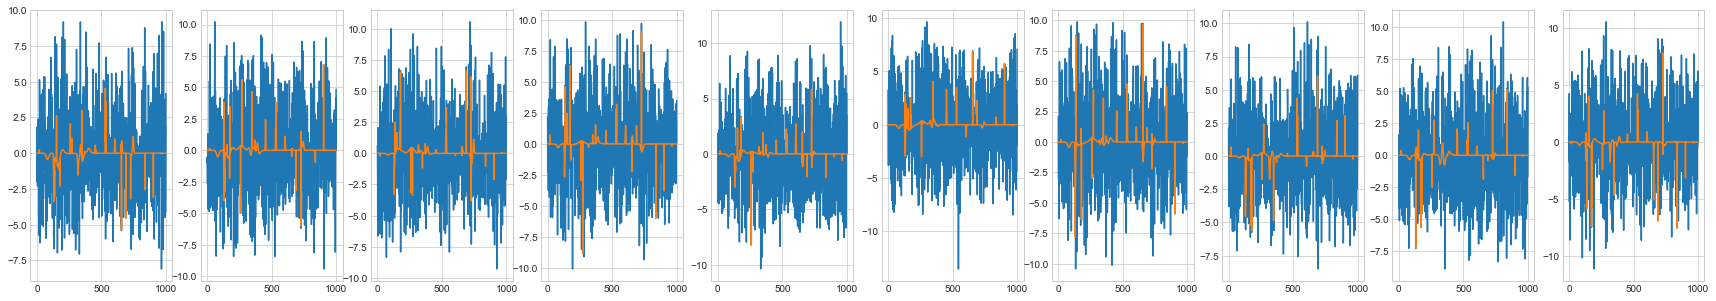

26th additional rbflayer
26th additional RBFlayer 0th epoch loss: 20.189542865159876
26th additional RBFlayer 999th epoch MSE Loss: 14.409896083590523
26th additional RBFlayer 1999th epoch MSE Loss: 14.375411888839288
26th additional RBFlayer 2999th epoch MSE Loss: 14.406662041914414
26th additional RBFlayer best loss : 14.371966276217329


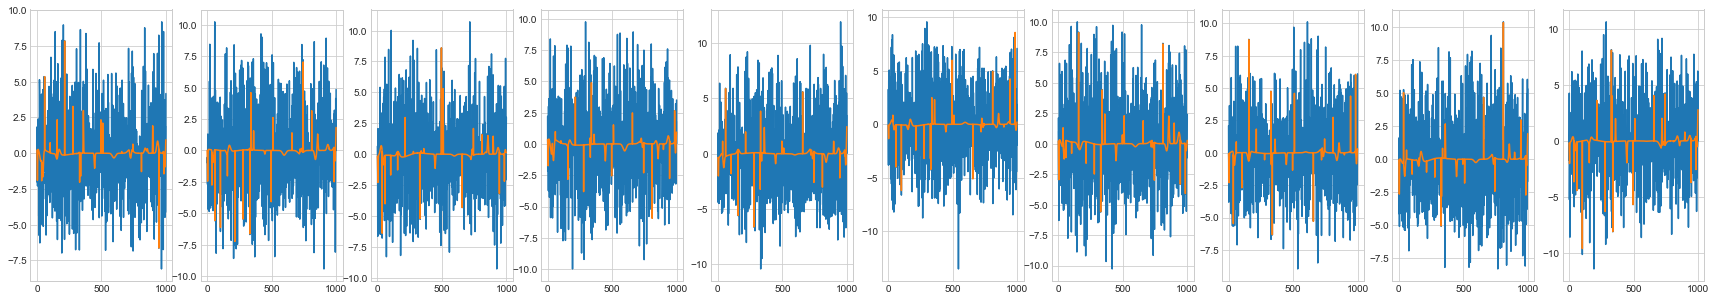

27th additional rbflayer
27th additional RBFlayer 0th epoch loss: 19.033927887234547
27th additional RBFlayer 999th epoch MSE Loss: 13.91117303717876
27th additional RBFlayer 1999th epoch MSE Loss: 13.930103035026423
27th additional RBFlayer 2999th epoch MSE Loss: 14.062421388511575
27th additional RBFlayer best loss : 13.907442940385497


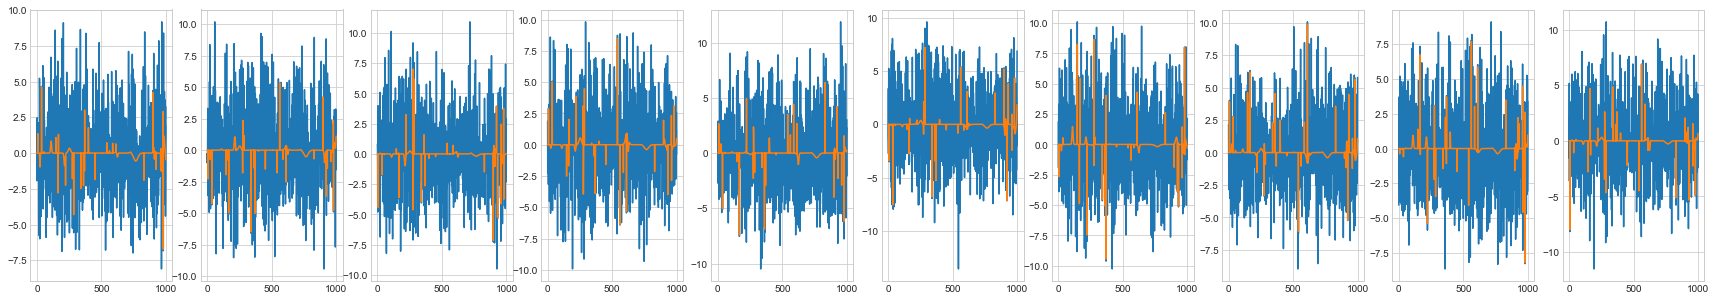

28th additional rbflayer
28th additional RBFlayer 0th epoch loss: 20.93170055335233
28th additional RBFlayer 999th epoch MSE Loss: 13.463081405646728
28th additional RBFlayer 1999th epoch MSE Loss: 13.414958689592579
28th additional RBFlayer 2999th epoch MSE Loss: 13.449532308893984
28th additional RBFlayer best loss : 13.392283542208691


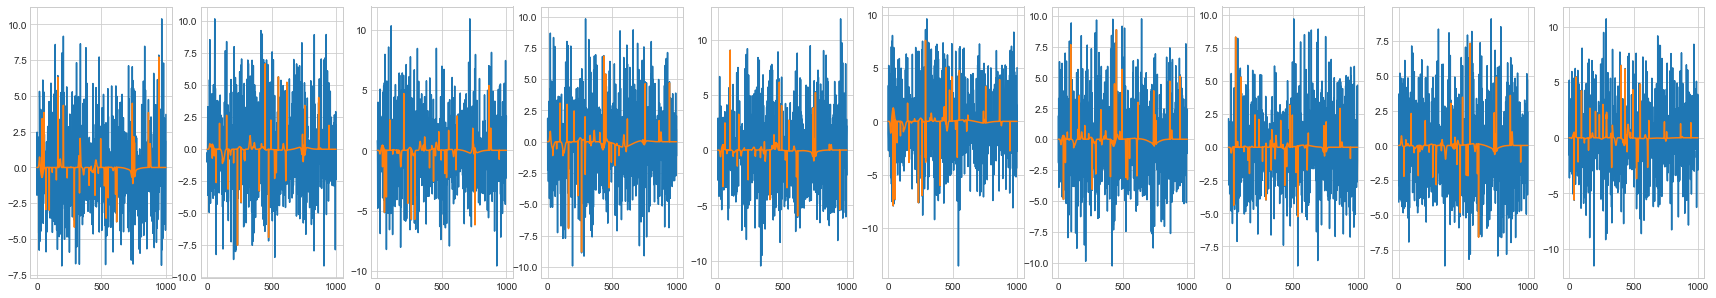

29th additional rbflayer
29th additional RBFlayer 0th epoch loss: 18.224577776840768
29th additional RBFlayer 999th epoch MSE Loss: 13.05740454207806
29th additional RBFlayer 1999th epoch MSE Loss: 13.040715112477017
29th additional RBFlayer 2999th epoch MSE Loss: 13.099516746030153
29th additional RBFlayer best loss : 13.007834141475525


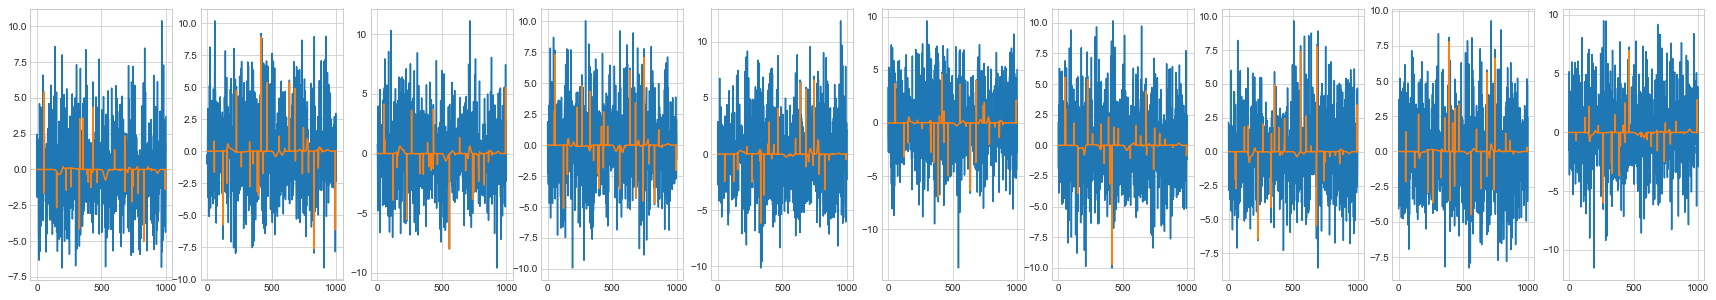

30th additional rbflayer
30th additional RBFlayer 0th epoch loss: 20.304782140343946
30th additional RBFlayer 999th epoch MSE Loss: 12.7024946973523
30th additional RBFlayer 1999th epoch MSE Loss: 12.704794705754587
30th additional RBFlayer 2999th epoch MSE Loss: 12.707109580101308
30th additional RBFlayer best loss : 12.690452582195995


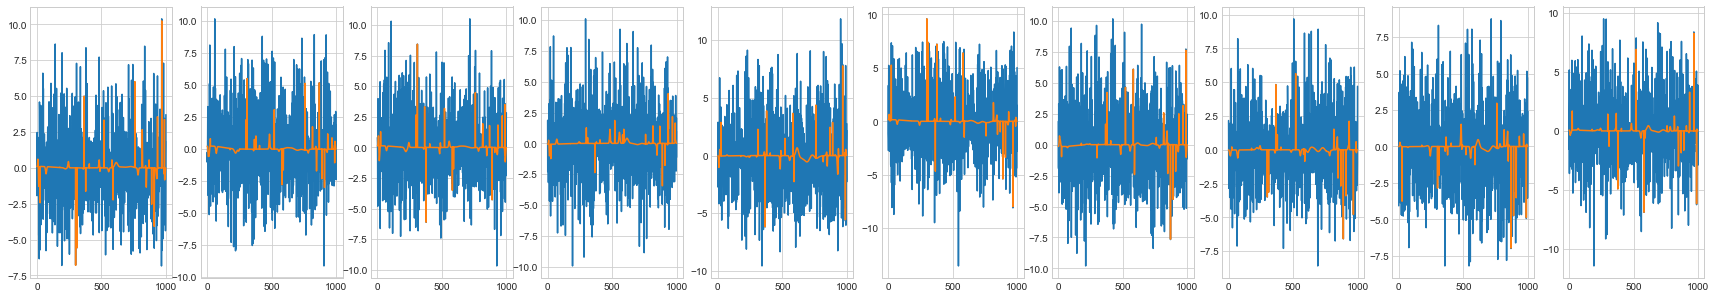

31th additional rbflayer
31th additional RBFlayer 0th epoch loss: 17.80251407955233
31th additional RBFlayer 999th epoch MSE Loss: 12.339733864445497
31th additional RBFlayer 1999th epoch MSE Loss: 12.330997060322515
31th additional RBFlayer 2999th epoch MSE Loss: 12.352044306608173
31th additional RBFlayer best loss : 12.310619628906634


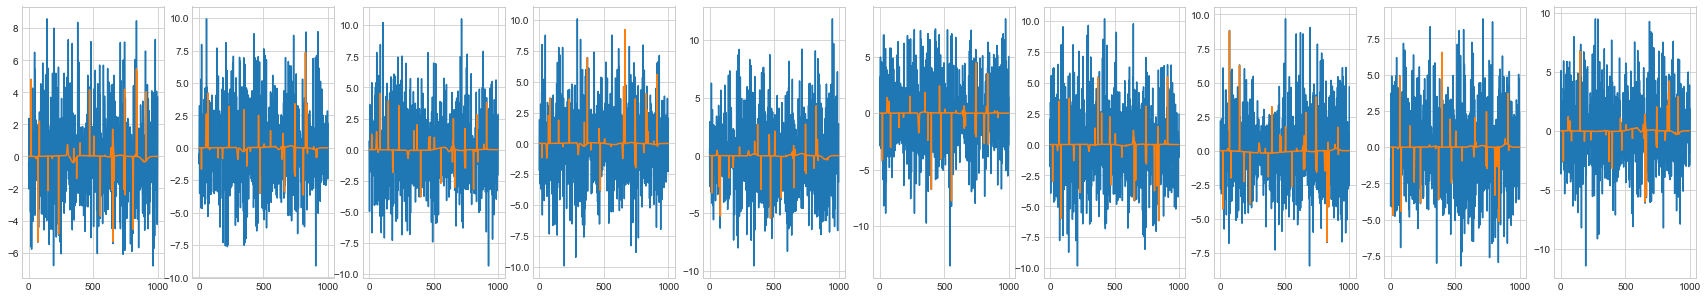

32th additional rbflayer
32th additional RBFlayer 0th epoch loss: 17.409833941023344
32th additional RBFlayer 999th epoch MSE Loss: 12.068603621879962
32th additional RBFlayer 1999th epoch MSE Loss: 12.037252959450639
32th additional RBFlayer 2999th epoch MSE Loss: 12.027028622502645
32th additional RBFlayer best loss : 12.027295345329941


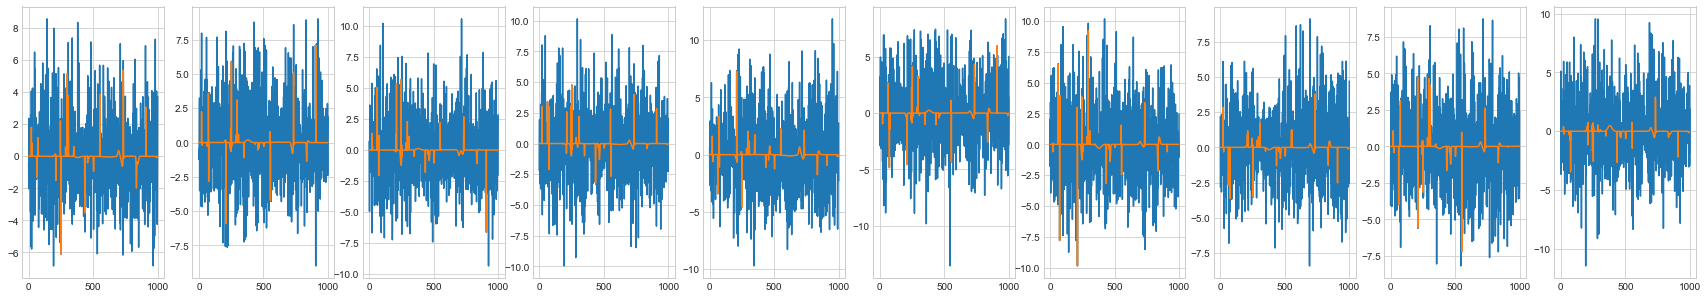

33th additional rbflayer
33th additional RBFlayer 0th epoch loss: 16.034197085968422
33th additional RBFlayer 999th epoch MSE Loss: 11.758349445747344
33th additional RBFlayer 1999th epoch MSE Loss: 11.729713193091154
33th additional RBFlayer 2999th epoch MSE Loss: 11.747986227152317
33th additional RBFlayer best loss : 11.717810564370991


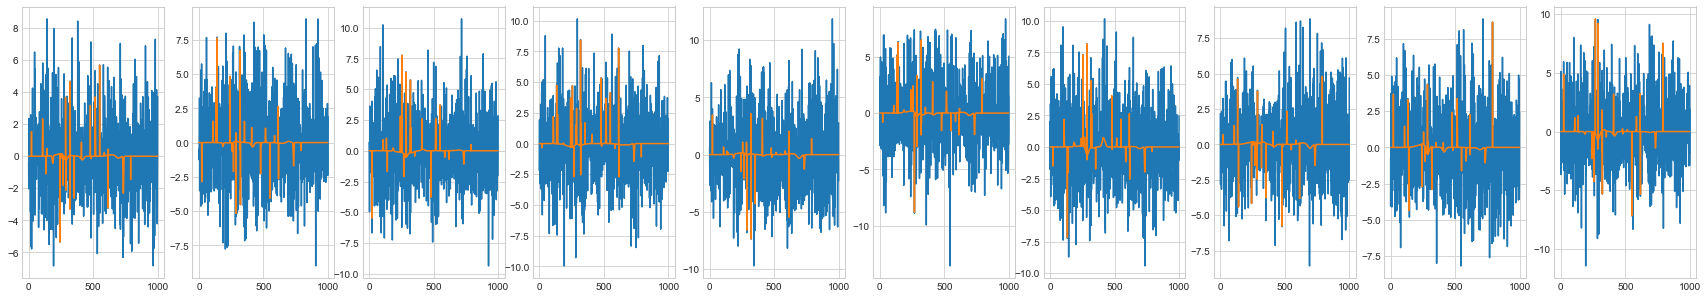

34th additional rbflayer
34th additional RBFlayer 0th epoch loss: 16.66167130803091
34th additional RBFlayer 999th epoch MSE Loss: 11.496037541810848
34th additional RBFlayer 1999th epoch MSE Loss: 11.46838115409933
34th additional RBFlayer 2999th epoch MSE Loss: 11.472750160984747
34th additional RBFlayer best loss : 11.44586063303777


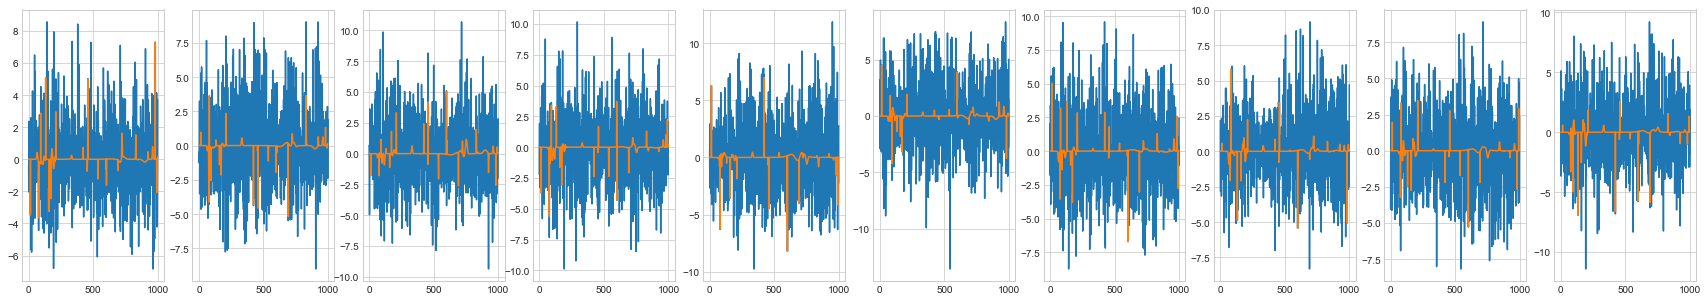

35th additional rbflayer
35th additional RBFlayer 0th epoch loss: 15.991180526759246
35th additional RBFlayer 999th epoch MSE Loss: 11.120762434648928
35th additional RBFlayer 1999th epoch MSE Loss: 11.12390533604904
35th additional RBFlayer 2999th epoch MSE Loss: 11.134245037316154
35th additional RBFlayer best loss : 11.093810506210167


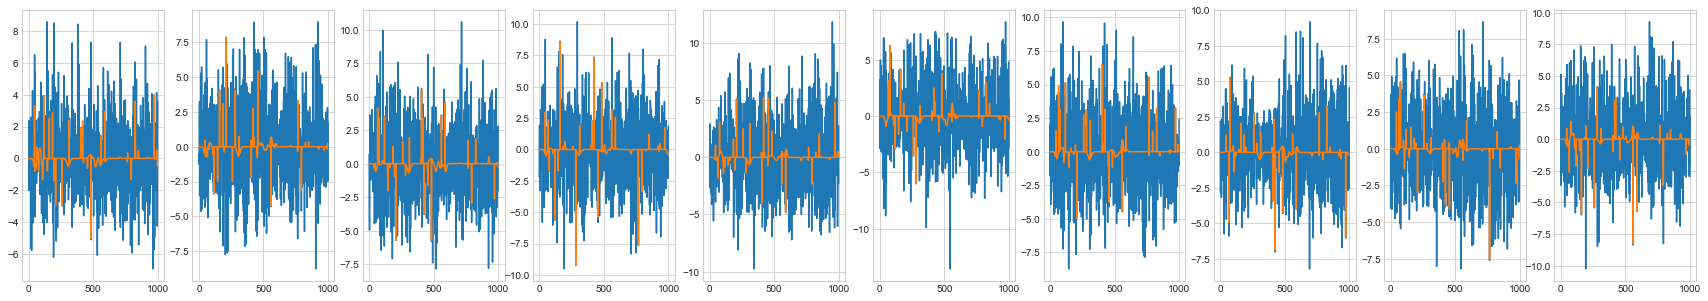

36th additional rbflayer
36th additional RBFlayer 0th epoch loss: 14.761766251773679
36th additional RBFlayer 999th epoch MSE Loss: 10.880358976268894
36th additional RBFlayer 1999th epoch MSE Loss: 10.830398567537408
36th additional RBFlayer 2999th epoch MSE Loss: 10.82964922365603
36th additional RBFlayer best loss : 10.826039283131093


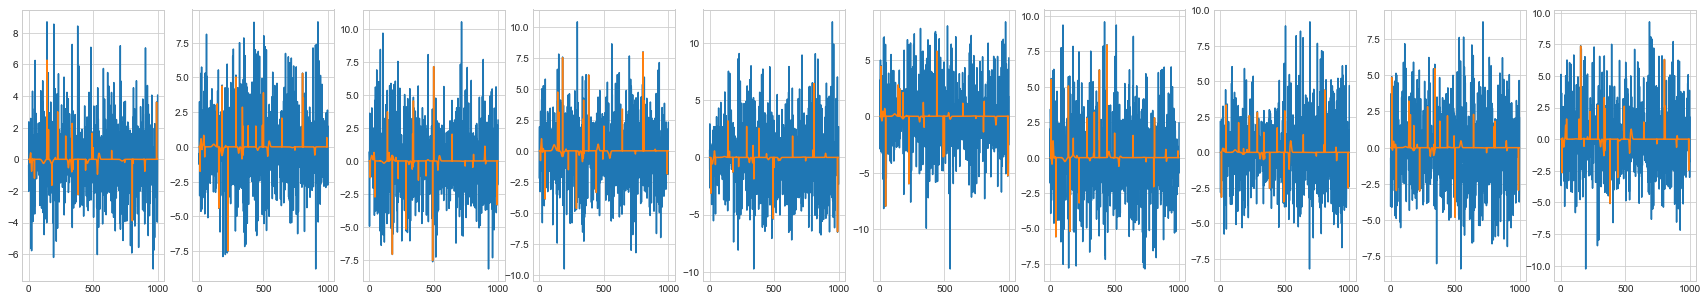

37th additional rbflayer
37th additional RBFlayer 0th epoch loss: 15.240306289169167
37th additional RBFlayer 999th epoch MSE Loss: 10.521539178240815
37th additional RBFlayer 1999th epoch MSE Loss: 10.549614048786761
37th additional RBFlayer 2999th epoch MSE Loss: 10.560590204329847
37th additional RBFlayer best loss : 10.518479340249987


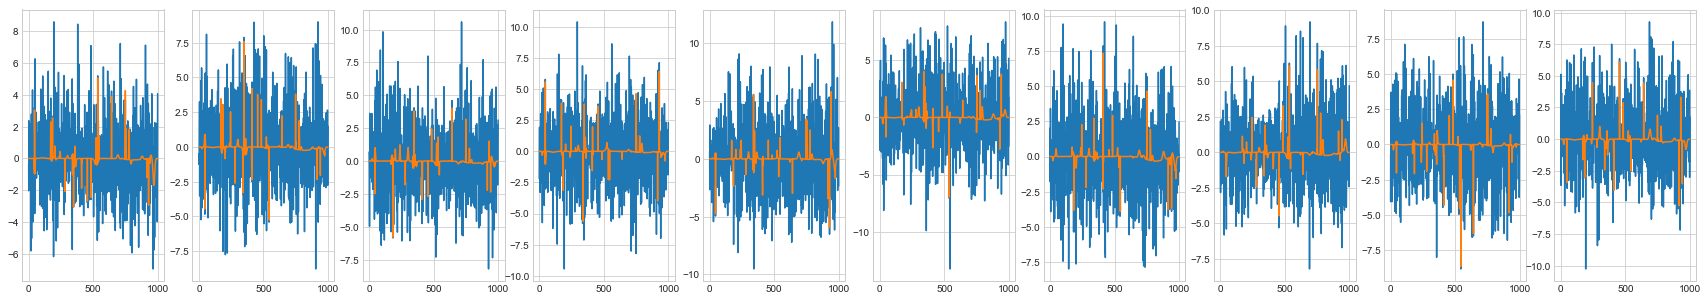

38th additional rbflayer
38th additional RBFlayer 0th epoch loss: 15.922765713049603
38th additional RBFlayer 999th epoch MSE Loss: 10.217630534539296
38th additional RBFlayer 1999th epoch MSE Loss: 10.198692861765592
38th additional RBFlayer 2999th epoch MSE Loss: 10.186215563312873
38th additional RBFlayer best loss : 10.167026724629093


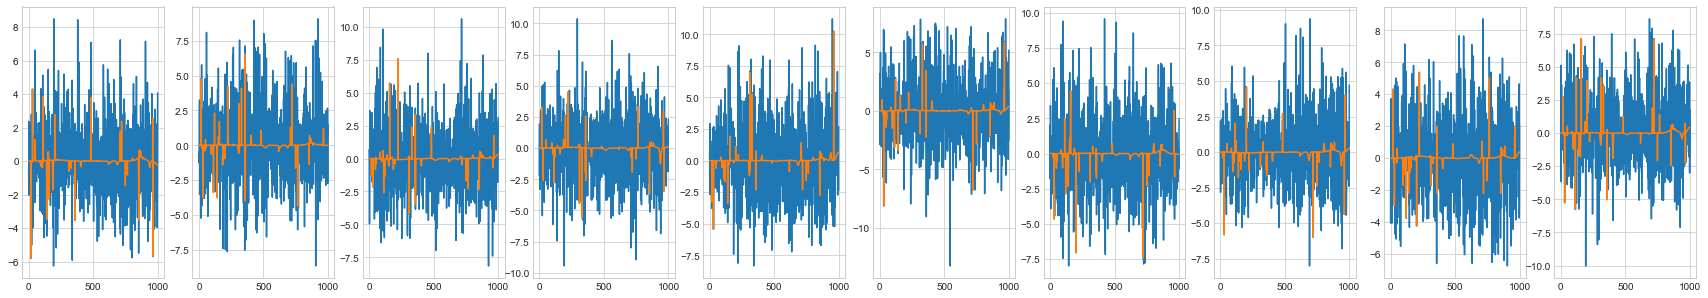

39th additional rbflayer
39th additional RBFlayer 0th epoch loss: 14.861618837965072
39th additional RBFlayer 999th epoch MSE Loss: 9.88751232244673
39th additional RBFlayer 1999th epoch MSE Loss: 9.865778493632325
39th additional RBFlayer 2999th epoch MSE Loss: 9.853755248323251
39th additional RBFlayer best loss : 9.853447079236187


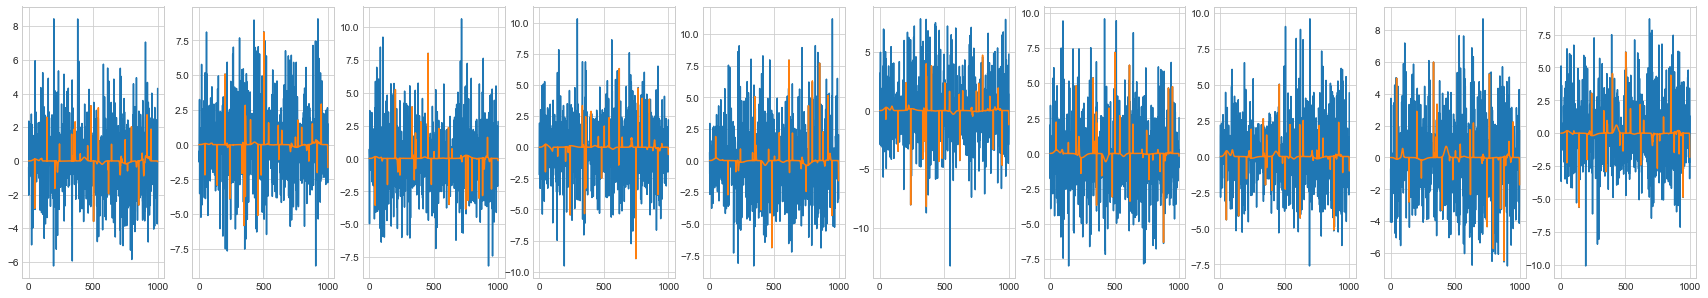

In [6]:
model_sim = MultiRBFnn(X.size(0), 100, device)
model_sim.train(input_, X, 3000, 0.0001, 10, 20)

In [10]:
model_pred = model_sim.pred(input_)[1]

In [23]:
class LSTM(nn.Module):
    def __init__(self, num_series, hidden):
        '''
        LSTM model with output layer to generate predictions.
        Args:
          num_series: number of input time series.
          hidden: number of hidden units.
        '''
        super(LSTM, self).__init__()
        self.p = num_series
        self.hidden = hidden

        # Set up network.
        self.lstm = nn.LSTM(num_series, hidden, batch_first=True)
        self.lstm.flatten_parameters()
        self.linear = nn.Conv1d(hidden, 1, 1)

    def init_hidden(self, batch):
        '''Initialize hidden states for LSTM cell.'''
        device = self.lstm.weight_ih_l0.device
        return (torch.zeros(1, batch, self.hidden, device=device),
                torch.zeros(1, batch, self.hidden, device=device))

    def forward(self, X, hidden=None):
        # Set up hidden state.
        if hidden is None:
            hidden = self.init_hidden(X.shape[0])

        # Apply LSTM.
        X, hidden = self.lstm(X, hidden)

        # Calculate predictions using output layer.
        X = X.transpose(2, 1)
        X = self.linear(X)
        return X.transpose(2, 1), hidden

In [56]:
class RBFGC(nn.Module):
    def __init__(self, num_series, hidden):
        super(RBFGC, self).__init__()

        self.p = num_series
        self.hidden = hidden
        self.networks = nn.ModuleList([LSTM(self.p - 1, self.hidden) for i in range(self.p)])

    def forward(self, X):
        if hidden is None:
            hidden = [None for _ in range(self.infeature)]

        pred = [self.networks[i](X[i], hidden[i]) for i in range(self.infeature)]
        pred, hidden = zip(*pred)
        pred = torch.cat(pred, dim=2)
        return pred, hidden
    
    def GC(self, threshold = True):
        GC = [torch.norm(net.lstm.weight_ih_l0, dim=0)
              for net in self.networks]
        GC = torch.stack(GC)
        if threshold:
            return (GC > 0).int()
        else:
            return GC

In [64]:
def make_dataset(RBF_model_pred, True_target, context):
    
    # input 은 해결
    Y = True_target.T
    Rx = True_target - RBF_model_pred

    assert context >= 1 and isinstance(context, int)
    input = torch.zeros(Y.size(-1), Y.size(0) - context, context, Y.size(-1) - 1,
                        dtype=torch.float32, device = device)
    target = torch.zeros(Y.size(0) - context, context, Y.size(-1),
                         dtype=torch.float32, device = device)
    R_input = torch.zeros_like(target)
    
    ##################################################################################
    
    for i in range(Y.size(-1)):
        
        if i == 0:
            Rx_feature = Rx[1:].T
        elif i == Y.size(0) - 1:
            Rx_feature = Rx[:-1].T
        else:
            Rx_feature = torch.cat((Rx[:i], Rx[i+1:])).T

        for j in range(context):
            start = j
            end = X.size(-1) - context + j
            input[i, :, j, :] = Rx_feature[start:end] 
            target[:, j, :] = Y[start+1:end+1]
            R_input[:, j, :] = RBF_model_pred.T[start:end]

    return input.detach(), target.detach(), R_input.detach()

def train_model_adam(rbfgc, X, RBF_model_pred, context, lr, max_iter, lam=0, lam_ridge=0,
                     lookback=5, check_every=50, verbose=1):
    '''Train model with Adam.'''
    p = X.shape[0]
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(rbfgc.parameters(), lr=lr)
    train_loss_list = []

    # Set up data.
    X, Y, R_X = make_dataset(RBF_model_pred, X, context)
    # X = torch.cat(X, dim=0)
    # Y = torch.cat(Y, dim=0)

    # For early stopping.
    best_it = None
    best_loss = np.inf
    best_model = None

    print(X.size())
    for it in range(max_iter):
        # Calculate loss.
        pred = [rbfgc.networks[i](X[i])[0] for i in range(p)]
        loss = sum([loss_fn(pred[i][:, :, 0] + R_X[:,:,i], Y[:, :, i]) for i in range(p)])

        # Add penalty term.
        if lam > 0:
            loss = loss + sum([regularize(net, lam) for net in rbfgc.networks])

        if lam_ridge > 0:
            loss = loss + sum([ridge_regularize(net, lam_ridge)
                               for net in rbfgc.networks])

        # Take gradient step.
        loss.backward()
        optimizer.step()
        rbfgc.zero_grad()

        # Check progress.
        if (it + 1) % check_every == 0:
            mean_loss = loss / p
            train_loss_list.append(mean_loss.detach())

            if verbose > 0:
                print(('-' * 10 + 'Iter = %d' + '-' * 10) % (it + 1))
                print('Loss = %f' % mean_loss)
                #print(torch.stack([torch.norm(net.lstm.weight_ih_l0, dim =0) for net in rbfgc.networks]))

            # Check for early stopping.
            if mean_loss < best_loss:
                best_loss = mean_loss
                best_it = it
                best_model = deepcopy(rbfgc)
            elif (it - best_it) == lookback * check_every:
                if verbose:
                    print('Stopping early')
                break

    # Restore best model.
    restore_parameters(rbfgc, best_model)

    return train_loss_list


In [65]:
def prox_update(network, lam, lr):
    '''Perform in place proximal update on first layer weight matrix.'''
    W = network.lstm.weight_ih_l0
    norm = torch.norm(W, dim=0, keepdim=True)
    W.data = ((W / torch.clamp(norm, min=(lam * lr)))
              * torch.clamp(norm - (lr * lam), min=0.0))
    network.lstm.flatten_parameters()


def regularize(network, lam):
    '''Calculate regularization term for first layer weight matrix.'''
    W = network.lstm.weight_ih_l0
    return lam * torch.sum(torch.norm(W, dim=0))


def ridge_regularize(network, lam):
    '''Apply ridge penalty at linear layer and hidden-hidden weights.'''
    return lam * (
        torch.sum(network.linear.weight ** 2) +
        torch.sum(network.lstm.weight_hh_l0 ** 2))

def restore_parameters(model, best_model):
    '''Move parameter values from best_model to model.'''
    for params, best_params in zip(model.parameters(), best_model.parameters()):
        params.data = best_params

In [66]:
from copy import deepcopy

In [67]:
rbfgc = RBFGC(10, 100).to(device)

In [68]:
train_loss_list = train_model_adam(rbfgc, X, model_pred, 10, 0.001, 500, check_every=100)

torch.Size([10, 990, 10, 9])
----------Iter = 100----------
Loss = 19.149931
----------Iter = 200----------
Loss = 7.882964
----------Iter = 300----------
Loss = 5.489649
----------Iter = 400----------
Loss = 4.623997
----------Iter = 500----------
Loss = 4.097706


In [69]:
torch.stack([torch.norm(net.lstm.weight_ih_l0, dim =0) for net in rbfgc.networks])

tensor([[3.7187, 4.1068, 4.0091, 3.3473, 3.5421, 3.8616, 3.8145, 3.9725, 3.5637],
        [4.1218, 4.0075, 3.8809, 3.8563, 4.0304, 4.1720, 3.8316, 3.9598, 4.0124],
        [3.8750, 3.3997, 4.0299, 4.0654, 3.6082, 3.8137, 3.8520, 3.7372, 3.6707],
        [4.2165, 3.7826, 3.7681, 3.7282, 3.9138, 3.8514, 3.8281, 3.9481, 3.8340],
        [4.1582, 3.6790, 4.0590, 3.8105, 3.6546, 3.7748, 3.7388, 3.9161, 3.8571],
        [4.0661, 4.1379, 4.0113, 3.8339, 4.0321, 3.7381, 4.0014, 3.7835, 3.9382],
        [3.8994, 3.7223, 3.7126, 3.4496, 3.6389, 3.5239, 3.9864, 3.7771, 3.8160],
        [4.3474, 3.8178, 3.9801, 3.9943, 3.6143, 3.9840, 3.4889, 3.7989, 3.8530],
        [4.2036, 4.0626, 3.8377, 4.2828, 3.6571, 3.8410, 4.0505, 4.2133, 4.0941],
        [4.1557, 3.5345, 3.7651, 3.8644, 3.7182, 3.5099, 3.6220, 3.7807, 3.8886]],
       device='cuda:0', grad_fn=<StackBackward0>)

In [70]:
X, Y, R_X = make_dataset(model_pred, X, 10)

In [72]:
X.size()

torch.Size([10, 990, 10, 9])

In [77]:
R_X[0]

tensor([[ 0.4657,  0.4620,  0.1802,  0.6819,  0.0407,  0.2859,  0.5056,  0.1787,
         -0.2712, -0.1506],
        [ 4.9351, 12.3556,  9.1227,  6.6078,  7.2703, -7.5350, -2.6776,  7.2797,
          1.9162,  3.5498],
        [ 5.5425,  1.4294, -0.4571,  5.7931,  3.5917,  2.1368,  3.4128,  1.9177,
          2.8630,  4.6837],
        [ 3.6789,  0.0828, -1.2580,  3.9043,  2.1581,  1.2939,  1.4652,  0.5800,
          1.0849,  2.9619],
        [-6.2381, -2.1656, -1.9067, -4.5423,  4.9599,  3.6573,  5.2356, -2.7570,
          3.2488, -1.7303],
        [ 3.3990, -1.2549,  2.5641,  2.2263,  1.4784,  3.5199,  0.8968,  1.7930,
         -1.1014,  1.7465],
        [ 8.4915,  0.0502,  7.1805,  6.0600,  4.7109,  7.7903,  4.8109,  5.8424,
          1.1363,  5.5655],
        [ 8.1149, -2.0250,  1.4578,  7.8628,  5.8650,  2.6769,  1.7687,  8.4135,
          0.8701, -3.9132],
        [-0.0921,  6.6748, -2.1767, 12.6219,  0.0140,  0.8034,  1.3097, 11.6344,
          4.4803, -1.6128],
        [ 0.6113, -

In [79]:
X.size()

torch.Size([10, 990, 10, 9])